### Libararies

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('/home/hrai/codes/hpe_library/')
from lib_import import *
from my_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
class Linear(nn.Module):
    def __init__(self, linear_size, p_dropout):
        """

        Args:
            linear_size (int): Number of nodes in the linear layers.
            p_dropout (float): Dropout probability.
        """
        super(Linear, self).__init__()

        self.relu = nn.ReLU(inplace=False)
        self.dropout = nn.Dropout(p_dropout)

        self.w1 = nn.Linear(linear_size, linear_size)
        self.bn1 = nn.BatchNorm1d(linear_size)

        self.w2 = nn.Linear(linear_size, linear_size)
        self.bn2 = nn.BatchNorm1d(linear_size)

    def forward(self, x):
        """Forward operations of the linear block.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            y (torch.Tensor): Output tensor.
        """
        h = self.w1(x)
        h = self.bn1(h)
        h = self.relu(h)
        h = self.dropout(h)

        h = self.w2(h)
        h = self.bn2(h)
        h = self.relu(h)
        h = self.dropout(h)

        y = x + h
        return y

In [27]:
dir_rep = 1024
input_tensor = torch.randn(8, 243, 17, dir_rep)

In [44]:
class linear_head(nn.Module):
    def __init__(self, linear_size=1024, out_dim=3, p_dropout=0.5):
        super(linear_head, self).__init__()

        self.linear_stages = nn.ModuleList()
        self.linear_stages.append(nn.Linear(linear_size, linear_size))
        self.linear_stages.append(nn.ReLU())
        self.linear_stages.append(nn.Dropout(p_dropout))            
        self.linear_stages.append(nn.Linear(linear_size, linear_size))
        self.linear_stages.append(nn.ReLU())
        self.linear_stages.append(nn.Dropout(p_dropout))
        self.linear_stages.append(nn.Linear(linear_size, int(linear_size/2)))
        self.linear_stages.append(nn.Linear(int(linear_size/2), out_dim))

    def forward(self, x):
        for linear in self.linear_stages:
            x = linear(x)
        return x

In [45]:
y = input_tensor.clone()
model = linear_head()
y = model(y)
y.shape

torch.Size([8, 243, 17, 3])

In [ ]:
def get_batch_gt(batch_size, num_frames, batch_pose, data_type=torch.float64):
    key_list = ['out', 'body_R_gt', 'z_axis_gt', 'y_axis_gt', 'x_axis_gt',
            'right_arm_link1_azim_gt', 'right_arm_link1_elev_gt', 'right_arm_link2_azim_gt', 'right_arm_link2_elev_gt',
            'left_arm_link1_azim_gt', 'left_arm_link1_elev_gt', 'left_arm_link2_azim_gt', 'left_arm_link2_elev_gt',
            'right_leg_link1_azim_gt', 'right_leg_link1_elev_gt', 'right_leg_link2_azim_gt', 'right_leg_link2_elev_gt',
            'left_leg_link1_azim_gt', 'left_leg_link1_elev_gt', 'left_leg_link2_azim_gt', 'left_leg_link2_elev_gt',
            'right_arm_root_tf_gt', 'left_arm_root_tf_gt', 'right_leg_root_tf_gt', 'left_leg_root_tf_gt',
            'right_arm_link1_tf_gt', 'right_arm_link2_tf_gt', 'right_arm_terminal_tf_gt',
            'left_arm_link1_tf_gt', 'left_arm_link2_tf_gt', 'left_arm_terminal_tf_gt',
            'right_leg_link1_tf_gt', 'right_leg_link2_tf_gt', 'right_leg_terminal_tf_gt',
            'left_leg_link1_tf_gt', 'left_leg_link2_tf_gt', 'left_leg_terminal_tf_gt',
            'right_arm_link1_dh_mat_gt', 'right_arm_link2_dh_mat_gt', 'right_arm_terminal_dh_mat_gt',
            'left_arm_link1_dh_mat_gt', 'left_arm_link2_dh_mat_gt', 'left_arm_terminal_dh_mat_gt',
            'right_leg_link1_dh_mat_gt', 'right_leg_link2_dh_mat_gt', 'right_leg_terminal_dh_mat_gt',
            'left_leg_link1_dh_mat_gt', 'left_leg_link2_dh_mat_gt', 'left_leg_terminal_dh_mat_gt'
            ]
    
    batch_gt = {}
    for key in key_list:
        if ('tf' in key) or ('dh_mat' in key):
            batch_gt[key] = torch.zeros((batch_size, num_frames, 4, 4), dtype=data_type).cuda()
        elif ('yaw' in key) or ('pitch' in key):
            batch_gt[key] = torch.zeros((batch_size, num_frames), dtype=data_type).cuda()
        elif 'R' in key:
            batch_gt[key] = torch.zeros((batch_size, num_frames, 3, 3), dtype=data_type).cuda()
        elif 'axis' in key:
            batch_gt[key] = torch.zeros((batch_size, num_frames, 3), dtype=data_type).cuda()
        elif 'out' in key:
            batch_gt[key] = torch.zeros((batch_size, num_frames, 45), dtype=data_type).cuda()
            
    for batch in range(batch_size):
        batch_init_pose = batch_pose[batch][0]
        dh_model = DHModel(batch_init_pose)
        for frame in range(num_frames):
            pose = batch_pose[batch][frame]
            dh_model.update_dh_model_from_pose(pose)
            #mpjpe = dh_model.mpjpe(pose)
            out = np.concatenate([dh_model.get_torso_keypoints(), dh_model.get_dh_angles()]) # 27 + 16
            #print(batch_gt['out'][batch, frame].shape, torch.tensor(out, dtype=torch.data_type).cuda().shape)
            batch_gt['out'][batch, frame] = torch.tensor(out, dtype=data_type).cuda()
            batch_gt['body_R_gt'][batch, frame] = torch.tensor(dh_model.body_R, dtype=data_type).cuda()
            batch_gt['z_axis_gt'][batch, frame] = torch.tensor(dh_model.z_axis, dtype=data_type).cuda()
            batch_gt['y_axis_gt'][batch, frame] = torch.tensor(dh_model.y_axis, dtype=data_type).cuda()
            batch_gt['x_axis_gt'][batch, frame] = torch.tensor(dh_model.x_axis, dtype=data_type).cuda()
            # right arm
            batch_gt['right_arm_link1_azim_gt'][batch, frame] = torch.tensor(dh_model.right_arm.link1_azim, dtype=data_type).cuda()
            batch_gt['right_arm_link1_elev_gt'][batch, frame] = torch.tensor(dh_model.right_arm.link1_elev, dtype=data_type).cuda()
            batch_gt['right_arm_link2_azim_gt'][batch, frame] = torch.tensor(dh_model.right_arm.link2_azim, dtype=data_type).cuda()
            batch_gt['right_arm_link2_elev_gt'][batch, frame] = torch.tensor(dh_model.right_arm.link2_elev, dtype=data_type).cuda()
            batch_gt['right_arm_root_tf_gt'][batch, frame] = torch.tensor(dh_model.right_arm.root_tf, dtype=data_type).cuda()
            batch_gt['right_arm_link1_dh_mat_gt'][batch, frame] = torch.tensor(dh_model.right_arm.link1_dh_mat, dtype=data_type).cuda()
            batch_gt['right_arm_link2_dh_mat_gt'][batch, frame] = torch.tensor(dh_model.right_arm.link2_dh_mat, dtype=data_type).cuda()
            batch_gt['right_arm_terminal_dh_mat_gt'][batch, frame] = torch.tensor(dh_model.right_arm.terminal_dh_mat, dtype=data_type).cuda()
            batch_gt['right_arm_link1_tf_gt'][batch, frame] = torch.tensor(dh_model.right_arm.link1_tf, dtype=data_type).cuda()
            batch_gt['right_arm_link2_tf_gt'][batch, frame] = torch.tensor(dh_model.right_arm.link2_tf, dtype=data_type).cuda()
            batch_gt['right_arm_terminal_tf_gt'][batch, frame] = torch.tensor(dh_model.right_arm.terminal_tf, dtype=data_type).cuda()
            # left arm
            batch_gt['left_arm_link1_azim_gt'][batch, frame] = torch.tensor(dh_model.left_arm.link1_azim, dtype=data_type).cuda()
            batch_gt['left_arm_link1_elev_gt'][batch, frame] = torch.tensor(dh_model.left_arm.link1_elev, dtype=data_type).cuda()
            batch_gt['left_arm_link2_azim_gt'][batch, frame] = torch.tensor(dh_model.left_arm.link2_azim, dtype=data_type).cuda()
            batch_gt['left_arm_link2_elev_gt'][batch, frame] = torch.tensor(dh_model.left_arm.link2_elev, dtype=data_type).cuda()
            batch_gt['left_arm_root_tf_gt'][batch, frame] = torch.tensor(dh_model.left_arm.root_tf, dtype=data_type).cuda()
            batch_gt['left_arm_link1_dh_mat_gt'][batch, frame] = torch.tensor(dh_model.left_arm.link1_dh_mat, dtype=data_type).cuda()
            batch_gt['left_arm_link2_dh_mat_gt'][batch, frame] = torch.tensor(dh_model.left_arm.link2_dh_mat, dtype=data_type).cuda()
            batch_gt['left_arm_terminal_dh_mat_gt'][batch, frame] = torch.tensor(dh_model.left_arm.terminal_dh_mat, dtype=data_type).cuda()
            batch_gt['left_arm_link1_tf_gt'][batch, frame] = torch.tensor(dh_model.left_arm.link1_tf, dtype=data_type).cuda()
            batch_gt['left_arm_link2_tf_gt'][batch, frame] = torch.tensor(dh_model.left_arm.link2_tf, dtype=data_type).cuda()
            batch_gt['left_arm_terminal_tf_gt'][batch, frame] = torch.tensor(dh_model.left_arm.terminal_tf, dtype=data_type).cuda()
            # right leg
            batch_gt['right_leg_link1_azim_gt'][batch, frame] = torch.tensor(dh_model.right_leg.link1_azim, dtype=data_type).cuda()
            batch_gt['right_leg_link1_elev_gt'][batch, frame] = torch.tensor(dh_model.right_leg.link1_elev, dtype=data_type).cuda()
            batch_gt['right_leg_link2_azim_gt'][batch, frame] = torch.tensor(dh_model.right_leg.link2_azim, dtype=data_type).cuda()
            batch_gt['right_leg_link2_elev_gt'][batch, frame] = torch.tensor(dh_model.right_leg.link2_elev, dtype=data_type).cuda()
            batch_gt['right_leg_root_tf_gt'][batch, frame] = torch.tensor(dh_model.right_leg.root_tf, dtype=data_type).cuda()
            batch_gt['right_leg_link1_dh_mat_gt'][batch, frame] = torch.tensor(dh_model.right_leg.link1_dh_mat, dtype=data_type).cuda()
            batch_gt['right_leg_link2_dh_mat_gt'][batch, frame] = torch.tensor(dh_model.right_leg.link2_dh_mat, dtype=data_type).cuda()
            batch_gt['right_leg_terminal_dh_mat_gt'][batch, frame] = torch.tensor(dh_model.right_leg.terminal_dh_mat, dtype=data_type).cuda()
            batch_gt['right_leg_link1_tf_gt'][batch, frame] = torch.tensor(dh_model.right_leg.link1_tf, dtype=data_type).cuda()
            batch_gt['right_leg_link2_tf_gt'][batch, frame] = torch.tensor(dh_model.right_leg.link2_tf, dtype=data_type).cuda()
            batch_gt['right_leg_terminal_tf_gt'][batch, frame] = torch.tensor(dh_model.right_leg.terminal_tf, dtype=data_type).cuda()
            # left leg
            batch_gt['left_leg_link1_azim_gt'][batch, frame] = torch.tensor(dh_model.left_leg.link1_azim, dtype=data_type).cuda()
            batch_gt['left_leg_link1_elev_gt'][batch, frame] = torch.tensor(dh_model.left_leg.link1_elev, dtype=data_type).cuda()
            batch_gt['left_leg_link2_azim_gt'][batch, frame] = torch.tensor(dh_model.left_leg.link2_azim, dtype=data_type).cuda()
            batch_gt['left_leg_link2_elev_gt'][batch, frame] = torch.tensor(dh_model.left_leg.link2_elev, dtype=data_type).cuda()
            batch_gt['left_leg_root_tf_gt'][batch, frame] = torch.tensor(dh_model.left_leg.root_tf, dtype=data_type).cuda()
            batch_gt['left_leg_link1_dh_mat_gt'][batch, frame] = torch.tensor(dh_model.left_leg.link1_dh_mat, dtype=data_type).cuda()
            batch_gt['left_leg_link2_dh_mat_gt'][batch, frame] = torch.tensor(dh_model.left_leg.link2_dh_mat, dtype=data_type).cuda()
            batch_gt['left_leg_terminal_dh_mat_gt'][batch, frame] = torch.tensor(dh_model.left_leg.terminal_dh_mat, dtype=data_type).cuda()
            batch_gt['left_leg_link1_tf_gt'][batch, frame] = torch.tensor(dh_model.left_leg.link1_tf, dtype=data_type).cuda()
            batch_gt['left_leg_link2_tf_gt'][batch, frame] = torch.tensor(dh_model.left_leg.link2_tf, dtype=data_type).cuda()
            batch_gt['left_leg_terminal_tf_gt'][batch, frame] = torch.tensor(dh_model.left_leg.terminal_tf, dtype=data_type).cuda()

    assert batch_pose.shape == (batch_size, num_frames, 17, 3), 'batch_gt shape is wrong' # [B, F, 17, 3]
    assert batch_gt['out'].shape == (batch_size, num_frames, 27+18), 'batch_dh shape is wrong' # [B, F, 27+18], 27 = 3*9, 18 = 2 + 4*4
    assert batch_gt['body_R_gt'].shape == (batch_size, num_frames, 3, 3), 'batch_body_R shape is wrong' # [B, F, 3, 3]
    assert batch_gt['z_axis_gt'].shape == (batch_size, num_frames, 3), 'batch_z_axis_gt shape is wrong' # [B, F, 3]
    assert batch_gt['y_axis_gt'].shape == (batch_size, num_frames, 3), 'batch_y_axis_gt shape is wrong' # [B, F, 3]
    assert batch_gt['x_axis_gt'].shape == (batch_size, num_frames, 3), 'batch_x_axis_gt shape is wrong' # [B, F, 3]
    assert batch_gt['right_arm_link1_azim_gt'].shape == (batch_size, num_frames), 'batch_right_arm_link1_azim_gt shape is wrong' # [B, F]
    assert batch_gt['right_arm_link1_tf_gt'].shape == (batch_size, num_frames, 4, 4), 'batch_right_arm_link1_mat_gt shape is wrong' # [B, F, 4, 4]
    
    return batch_gt


def check_dh_model(batch_pose, batch_gt, batch_size, num_frames, data_type=torch.float64):
    # get keypoints
    batch_keypoints = batch_gt['out'][:, :, :27].reshape(batch_gt['out'].shape[0], batch_gt['out'].shape[1], 9, 3) # [B, F, 9, 3]
    batch_dh_angles = batch_gt['out'][:, :, 27:] # [B, F, 16]
    assert batch_keypoints.shape == (batch_size, num_frames, 9, 3), 'batch_keypoints shape is wrong' # [B, F, 9, 3]
    assert batch_dh_angles.shape == (batch_size, num_frames, 18), 'batch_dh_angles shape is wrong' # [B, F, 18]
    
    batch_pelvis     = batch_keypoints[:, :, 0, :] # [B, F, 3]
    batch_r_hip      = batch_keypoints[:, :, 1, :] # [B, F, 3]
    batch_l_hip      = batch_keypoints[:, :, 2, :] # [B, F, 3]
    batch_torso      = batch_keypoints[:, :, 3, :] # [B, F, 3]
    batch_neck       = batch_keypoints[:, :, 4, :] # [B, F, 3]
    batch_nose       = batch_keypoints[:, :, 5, :] # [B, F, 3]
    batch_head       = batch_keypoints[:, :, 6, :] # [B, F, 3]
    batch_l_shoulder = batch_keypoints[:, :, 7, :] # [B, F, 3]
    batch_r_shoulder = batch_keypoints[:, :, 8, :] # [B, F, 3]

    batch_pelvis_gt     = batch_pose[:, :, 0] # [B, F, 3]
    batch_r_hip_gt      = batch_pose[:, :, 1] # [B, F, 3]
    batch_l_hip_gt      = batch_pose[:, :, 4] # [B, F, 3]
    batch_r_shoulder_gt = batch_pose[:, :, 14] # [B, F, 3]
    batch_l_shoulder_gt = batch_pose[:, :, 11] # [B, F, 3]
    batch_r_elbow_gt    = batch_pose[:, :, 15] # [B, F, 3]
    batch_r_wrist_gt    = batch_pose[:, :, 16] # [B, F, 3]
    batch_l_elbow_gt    = batch_pose[:, :, 12] # [B, F, 3]
    batch_l_wrist_gt    = batch_pose[:, :, 13] # [B, F, 3]
    batch_r_knee_gt     = batch_pose[:, :, 2] # [B, F, 3]
    batch_r_ankle_gt    = batch_pose[:, :, 3] # [B, F, 3]
    batch_l_knee_gt     = batch_pose[:, :, 5] # [B, F, 3]
    batch_l_ankle_gt    = batch_pose[:, :, 6] # [B, F, 3]

    assert torch.norm(batch_pelvis - batch_pelvis_gt) < 1e-6, 'batch_pelvis is wrong'
    assert torch.norm(batch_r_hip - batch_r_hip_gt) < 1e-6, 'batch_r_hip is wrong'
    assert torch.norm(batch_l_hip - batch_l_hip_gt) < 1e-6, 'batch_l_hip is wrong'
    assert torch.norm(batch_r_shoulder - batch_r_shoulder_gt) < 1e-6, 'batch_r_shoulder is wrong'
    assert torch.norm(batch_l_shoulder - batch_l_shoulder_gt) < 1e-6, 'batch_l_shoulder is wrong'

    # get dh angles
    
    batch_right_arm_link1_azim   = batch_dh_angles[:, :, 2] # [B, F]
    batch_right_arm_link1_elev = batch_dh_angles[:, :, 3] # [B, F]
    batch_right_arm_link2_azim   = batch_dh_angles[:, :, 4] # [B, F]
    batch_right_arm_link2_elev = batch_dh_angles[:, :, 5] # [B, F]
    batch_left_arm_link1_azim    = batch_dh_angles[:, :, 6] # [B, F]
    batch_left_arm_link1_elev  = batch_dh_angles[:, :, 7] # [B, F]
    batch_left_arm_link2_azim    = batch_dh_angles[:, :, 8] # [B, F]
    batch_left_arm_link2_elev  = batch_dh_angles[:, :, 9] # [B, F]
    batch_right_leg_link1_azim   = batch_dh_angles[:, :, 10] # [B, F]
    batch_right_leg_link1_elev = batch_dh_angles[:, :, 11] # [B, F]
    batch_right_leg_link2_azim   = batch_dh_angles[:, :, 12] # [B, F]
    batch_right_leg_link2_elev = batch_dh_angles[:, :, 13] # [B, F]
    batch_left_leg_link1_azim    = batch_dh_angles[:, :, 14] # [B, F]
    batch_left_leg_link1_elev  = batch_dh_angles[:, :, 15] # [B, F]
    batch_left_leg_link2_azim    = batch_dh_angles[:, :, 16] # [B, F]
    batch_left_leg_link2_elev  = batch_dh_angles[:, :, 17] # [B, F]
    assert torch.norm(batch_right_arm_link1_azim - batch_gt['right_arm_link1_azim_gt']) < 1e-6, 'batch_right_arm_link1_azim is wrong'
    assert torch.norm(batch_right_arm_link1_elev - batch_gt['right_arm_link1_elev_gt']) < 1e-6, 'batch_right_arm_link1_elev is wrong'
    assert torch.norm(batch_right_arm_link2_azim - batch_gt['right_arm_link2_azim_gt']) < 1e-6, 'batch_right_arm_link2_azim is wrong'
    assert torch.norm(batch_right_arm_link2_elev - batch_gt['right_arm_link2_elev_gt']) < 1e-6, 'batch_right_arm_link2_elev is wrong'
    assert torch.norm(batch_left_arm_link1_azim - batch_gt['left_arm_link1_azim_gt']) < 1e-6, 'batch_left_arm_link1_azim is wrong'
    assert torch.norm(batch_left_arm_link1_elev - batch_gt['left_arm_link1_elev_gt']) < 1e-6, 'batch_left_arm_link1_elev is wrong'
    assert torch.norm(batch_left_arm_link2_azim - batch_gt['left_arm_link2_azim_gt']) < 1e-6, 'batch_left_arm_link2_azim is wrong'
    assert torch.norm(batch_left_arm_link2_elev - batch_gt['left_arm_link2_elev_gt']) < 1e-6, 'batch_left_arm_link2_elev is wrong'
    assert torch.norm(batch_right_leg_link1_azim - batch_gt['right_leg_link1_azim_gt']) < 1e-6, 'batch_right_leg_link1_azim is wrong'
    assert torch.norm(batch_right_leg_link1_elev - batch_gt['right_leg_link1_elev_gt']) < 1e-6, 'batch_right_leg_link1_elev is wrong'
    assert torch.norm(batch_right_leg_link2_azim - batch_gt['right_leg_link2_azim_gt']) < 1e-6, 'batch_right_leg_link2_azim is wrong'
    assert torch.norm(batch_right_leg_link2_elev - batch_gt['right_leg_link2_elev_gt']) < 1e-6, 'batch_right_leg_link2_elev is wrong'
    assert torch.norm(batch_left_leg_link1_azim - batch_gt['left_leg_link1_azim_gt']) < 1e-6, 'batch_left_leg_link1_azim is wrong'
    assert torch.norm(batch_left_leg_link1_elev - batch_gt['left_leg_link1_elev_gt']) < 1e-6, 'batch_left_leg_link1_elev is wrong'
    assert torch.norm(batch_left_leg_link2_azim - batch_gt['left_leg_link2_azim_gt']) < 1e-6, 'batch_left_leg_link2_azim is wrong'
    assert torch.norm(batch_left_leg_link2_elev - batch_gt['left_leg_link2_elev_gt']) < 1e-6, 'batch_left_leg_link2_elev is wrong'


    ## get body reference frame
    # z axis
    batch_z_axis = torch.tensor([0, 0, 1], dtype=data_type).unsqueeze(0).unsqueeze(0).repeat(batch_size, num_frames, 1).cuda() # [B, F, 3]
    assert torch.norm(batch_z_axis - batch_gt['z_axis_gt']) < 1e-6, 'batch_z_axis is wrong'
    # y axis
    batch_y_axis = batch_l_hip - batch_pelvis # [B, F, 3]
    batch_y_axis[:, :, 2] = 0
    batch_y_axis /= torch.norm(batch_y_axis, dim=2).unsqueeze(-1)
    assert torch.norm(batch_y_axis - batch_gt['y_axis_gt']) < 1e-5, 'batch_y_axis is wrong'
    # x axis
    batch_x_axis = torch.cross(batch_y_axis, batch_z_axis, dim=2) # [B, F, 3]
    assert torch.norm(batch_x_axis - batch_gt['x_axis_gt']) < 1e-5, 'batch_x_axis is wrong'
    # body_R
    batch_body_R = torch.cat([batch_x_axis.unsqueeze(-1), batch_y_axis.unsqueeze(-1), batch_z_axis.unsqueeze(-1)], dim=-1).transpose(2, 3) # [B, F, 3, 3]
    assert torch.norm(batch_body_R - batch_gt['body_R_gt']) < 1e-5, 'batch_body_R is wrong'

    ## get limb length from pose
    batch_limb_lens = get_limb_lens(batch_pose) # [B, F, 16]
    batch_init_limb_lens = batch_limb_lens[:, 0, :] # [B, 16]
    batch_ra_l1_length = batch_init_limb_lens[:, 14].unsqueeze(1).repeat(1, num_frames) # [B, F]
    batch_ra_l2_length = batch_init_limb_lens[:, 15].unsqueeze(1).repeat(1, num_frames) # [B, F]
    batch_la_l1_length = batch_init_limb_lens[:, 11].unsqueeze(1).repeat(1, num_frames) # [B, F]
    batch_la_l2_length = batch_init_limb_lens[:, 12].unsqueeze(1).repeat(1, num_frames) # [B, F]
    batch_rl_l1_length = batch_init_limb_lens[:, 1].unsqueeze(1).repeat(1, num_frames) # [B, F]
    batch_rl_l2_length = batch_init_limb_lens[:, 2].unsqueeze(1).repeat(1, num_frames) # [B, F]
    batch_ll_l1_length = batch_init_limb_lens[:, 4].unsqueeze(1).repeat(1, num_frames) # [B, F]
    batch_ll_l2_length = batch_init_limb_lens[:, 5].unsqueeze(1).repeat(1, num_frames) # [B, F]

    ## root tf
    rot_y_180 = torch.tensor(Rotation.from_rotvec(np.array([0, np.pi, 0])).as_matrix(), dtype=data_type).cuda() # [3, 3]
    root_tf = torch.eye(4, dtype=data_type).unsqueeze(0).unsqueeze(0).unsqueeze(0).repeat(batch_size, num_frames, 4, 1, 1).cuda()
    root_tf[:, :, :, :3, :3] = torch.matmul(rot_y_180.clone().detach(), batch_body_R.clone().detach()).unsqueeze(2).repeat(1, 1, 4, 1, 1) # [B, F, 4, 3, 3]
    root_tf[:, :, 0, :3, 3] = batch_r_shoulder # right arm
    root_tf[:, :, 1, :3, 3] = batch_l_shoulder # left arm
    root_tf[:, :, 2, :3, 3] = batch_r_hip # right leg
    root_tf[:, :, 3, :3, 3] = batch_l_hip # left leg
    assert torch.norm(root_tf[:, :, 0] - batch_gt['right_arm_root_tf_gt']) < 1e-5, 'right arm root_tf is wrong'
    assert torch.norm(root_tf[:, :, 1] - batch_gt['left_arm_root_tf_gt']) < 1e-5, 'left arm root_tf is wrong'
    assert torch.norm(root_tf[:, :, 2] - batch_gt['right_leg_root_tf_gt']) < 1e-5, 'right leg root_tf is wrong'
    assert torch.norm(root_tf[:, :, 3] - batch_gt['left_leg_root_tf_gt']) < 1e-5, 'left leg root_tf is wrong'


    ## dh tf
    batch_zero = torch.zeros_like(batch_gt['right_arm_link1_azim_gt'], dtype=data_type)

    # right_arm
    batch_right_arm_link1_mat = batch_DH_matrix(batch_gt['right_arm_link1_azim_gt'], batch_gt['right_arm_link1_elev_gt'], batch_zero, batch_zero) # [B, F, 4, 4]
    assert torch.norm(batch_right_arm_link1_mat - batch_gt['right_arm_link1_dh_mat_gt']) < 1e-5, 'batch_right_arm_link1_mat is wrong'
    batch_right_arm_link2_mat = batch_DH_matrix(batch_gt['right_arm_link2_azim_gt'], batch_gt['right_arm_link2_elev_gt'], batch_zero, batch_ra_l1_length) # [B, F, 4, 4]
    assert torch.norm(batch_right_arm_link2_mat - batch_gt['right_arm_link2_dh_mat_gt']) < 1e-5, 'batch_right_arm_link2_mat is wrong'
    batch_right_arm_terminal_mat = batch_DH_matrix(batch_zero, batch_zero, batch_zero, batch_ra_l2_length) # [B, F, 4, 4]
    assert torch.norm(batch_right_arm_terminal_mat - batch_gt['right_arm_terminal_dh_mat_gt']) < 1e-5, 'batch_right_arm_terminal_mat is wrong'
    
    batch_right_arm_link1_tf = torch.matmul(root_tf[:, :, 0, :, :], batch_right_arm_link1_mat) # [B, F, 4, 4]
    assert torch.norm(batch_right_arm_link1_tf - batch_gt['right_arm_link1_tf_gt']) < 1e-5, 'batch_right_arm_link1_mat is wrong'
    batch_right_arm_link2_tf = torch.matmul(batch_right_arm_link1_tf, batch_right_arm_link2_mat) # [B, F, 4, 4]
    assert torch.norm(batch_right_arm_link2_tf - batch_gt['right_arm_link2_tf_gt']) < 1e-5, 'batch_right_arm_link2_mat is wrong'
    batch_right_arm_terminal_tf = torch.matmul(batch_right_arm_link2_tf, batch_right_arm_terminal_mat) # [B, F, 4, 4]
    assert torch.norm(batch_right_arm_terminal_tf - batch_gt['right_arm_terminal_tf_gt']) < 1e-5, 'batch_right_arm_terminal_mat is wrong'
    batch_right_elbow = batch_right_arm_link2_tf[:, :, :3, 3] # [B, F, 3]
    assert torch.norm(batch_right_elbow - batch_r_elbow_gt) < 1e-5, 'batch_right_elbow is wrong'
    batch_right_wrist = batch_right_arm_terminal_tf[:, :, :3, 3] # [B, F, 3]
    assert torch.norm(batch_right_wrist - batch_r_wrist_gt) < 1e-5, 'batch_right_wrist is wrong'

    # left_arm
    batch_left_arm_link1_mat = batch_DH_matrix(batch_gt['left_arm_link1_azim_gt'], batch_gt['left_arm_link1_elev_gt'], batch_zero, batch_zero) # [B, F, 4, 4]
    assert torch.norm(batch_left_arm_link1_mat - batch_gt['left_arm_link1_dh_mat_gt']) < 1e-5, 'batch_left_arm_link1_mat is wrong'
    batch_left_arm_link2_mat = batch_DH_matrix(batch_gt['left_arm_link2_azim_gt'], batch_gt['left_arm_link2_elev_gt'], batch_zero, batch_la_l1_length) # [B, F, 4, 4]
    assert torch.norm(batch_left_arm_link2_mat - batch_gt['left_arm_link2_dh_mat_gt']) < 1e-4, 'batch_left_arm_link2_mat is wrong'
    batch_left_arm_terminal_mat = batch_DH_matrix(batch_zero, batch_zero, batch_zero, batch_la_l2_length) # [B, F, 4, 4]
    assert torch.norm(batch_left_arm_terminal_mat - batch_gt['left_arm_terminal_dh_mat_gt']) < 1e-5, 'batch_left_arm_terminal_mat is wrong'
    
    batch_left_arm_link1_tf = torch.matmul(root_tf[:, :, 1, :, :], batch_left_arm_link1_mat) # [B, F, 4, 4]
    assert torch.norm(batch_left_arm_link1_tf - batch_gt['left_arm_link1_tf_gt']) < 1e-5, 'batch_left_arm_link1_mat is wrong'
    batch_left_arm_link2_tf = torch.matmul(batch_left_arm_link1_tf, batch_left_arm_link2_mat) # [B, F, 4, 4]
    assert torch.norm(batch_left_arm_link2_tf - batch_gt['left_arm_link2_tf_gt']) < 1e-5, 'batch_left_arm_link2_mat is wrong'
    batch_left_arm_terminal_tf = torch.matmul(batch_left_arm_link2_tf, batch_left_arm_terminal_mat) # [B, F, 4, 4]
    assert torch.norm(batch_left_arm_terminal_tf - batch_gt['left_arm_terminal_tf_gt']) < 1e-5, 'batch_left_arm_terminal_mat is wrong'
    batch_left_elbow = batch_left_arm_link2_tf[:, :, :3, 3] # [B, F, 3]
    assert torch.norm(batch_left_elbow - batch_l_elbow_gt) < 1e-5, 'batch_left_elbow is wrong'
    batch_left_wrist = batch_left_arm_terminal_tf[:, :, :3, 3] # [B, F, 3]
    assert torch.norm(batch_left_wrist - batch_l_wrist_gt) < 1e-5, 'batch_left_wrist is wrong'

    # right_leg
    batch_right_leg_link1_mat = batch_DH_matrix(batch_gt['right_leg_link1_azim_gt'], batch_gt['right_leg_link1_elev_gt'], batch_zero, batch_zero) # [B, F, 4, 4]
    assert torch.norm(batch_right_leg_link1_mat - batch_gt['right_leg_link1_dh_mat_gt']) < 1e-5, 'batch_right_leg_link1_mat is wrong'
    batch_right_leg_link2_mat = batch_DH_matrix(batch_gt['right_leg_link2_azim_gt'], batch_gt['right_leg_link2_elev_gt'], batch_zero, batch_rl_l1_length) # [B, F, 4, 4]
    assert torch.norm(batch_right_leg_link2_mat - batch_gt['right_leg_link2_dh_mat_gt']) < 1e-5, 'batch_right_leg_link2_mat is wrong'
    batch_right_leg_terminal_mat = batch_DH_matrix(batch_zero, batch_zero, batch_zero, batch_rl_l2_length) # [B, F, 4, 4]
    assert torch.norm(batch_right_leg_terminal_mat - batch_gt['right_leg_terminal_dh_mat_gt']) < 1e-5, 'batch_right_leg_terminal_mat is wrong'
    
    batch_right_leg_link1_tf = torch.matmul(root_tf[:, :, 2, :, :], batch_right_leg_link1_mat) # [B, F, 4, 4]
    assert torch.norm(batch_right_leg_link1_tf - batch_gt['right_leg_link1_tf_gt']) < 1e-5, 'batch_right_leg_link1_mat is wrong'
    batch_right_leg_link2_tf = torch.matmul(batch_right_leg_link1_tf, batch_right_leg_link2_mat) # [B, F, 4, 4]
    assert torch.norm(batch_right_leg_link2_tf - batch_gt['right_leg_link2_tf_gt']) < 1e-5, 'batch_right_leg_link2_mat is wrong'
    batch_right_leg_terminal_tf = torch.matmul(batch_right_leg_link2_tf, batch_right_leg_terminal_mat) # [B, F, 4, 4]
    assert torch.norm(batch_right_leg_terminal_tf - batch_gt['right_leg_terminal_tf_gt']) < 1e-5, 'batch_right_leg_terminal_mat is wrong'
    batch_right_knee = batch_right_leg_link2_tf[:, :, :3, 3] # [B, F, 3]
    assert torch.norm(batch_right_knee - batch_r_knee_gt) < 1e-5, 'batch_right_knee is wrong'
    batch_right_ankle = batch_right_leg_terminal_tf[:, :, :3, 3] # [B, F, 3]
    assert torch.norm(batch_right_ankle - batch_r_ankle_gt) < 1e-5, 'batch_right_ankle is wrong'

    # left_leg
    batch_left_leg_link1_mat = batch_DH_matrix(batch_gt['left_leg_link1_azim_gt'], batch_gt['left_leg_link1_elev_gt'], batch_zero, batch_zero) # [B, F, 4, 4]
    assert torch.norm(batch_left_leg_link1_mat - batch_gt['left_leg_link1_dh_mat_gt']) < 1e-5, 'batch_left_leg_link1_mat is wrong'
    batch_left_leg_link2_mat = batch_DH_matrix(batch_gt['left_leg_link2_azim_gt'], batch_gt['left_leg_link2_elev_gt'], batch_zero, batch_ll_l1_length) # [B, F, 4, 4]
    assert torch.norm(batch_left_leg_link2_mat - batch_gt['left_leg_link2_dh_mat_gt']) < 1e-5, 'batch_left_leg_link2_mat is wrong'
    batch_left_leg_terminal_mat = batch_DH_matrix(batch_zero, batch_zero, batch_zero, batch_ll_l2_length) # [B, F, 4, 4]
    assert torch.norm(batch_left_leg_terminal_mat - batch_gt['left_leg_terminal_dh_mat_gt']) < 1e-5, 'batch_left_leg_terminal_mat is wrong'

    batch_left_leg_link1_tf = torch.matmul(root_tf[:, :, 3, :, :], batch_left_leg_link1_mat) # [B, F, 4, 4]
    assert torch.norm(batch_left_leg_link1_tf - batch_gt['left_leg_link1_tf_gt']) < 1e-5, 'batch_left_leg_link1_mat is wrong'
    batch_left_leg_link2_tf = torch.matmul(batch_left_leg_link1_tf, batch_left_leg_link2_mat) # [B, F, 4, 4]
    assert torch.norm(batch_left_leg_link2_tf - batch_gt['left_leg_link2_tf_gt']) < 1e-5, 'batch_left_leg_link2_mat is wrong'
    batch_left_leg_terminal_tf = torch.matmul(batch_left_leg_link2_tf, batch_left_leg_terminal_mat) # [B, F, 4, 4]
    assert torch.norm(batch_left_leg_terminal_tf - batch_gt['left_leg_terminal_tf_gt']) < 1e-5, 'batch_left_leg_terminal_mat is wrong'
    batch_left_knee = batch_left_leg_link2_tf[:, :, :3, 3] # [B, F, 3]
    assert torch.norm(batch_left_knee - batch_l_knee_gt) < 1e-5, 'batch_left_knee is wrong'
    batch_left_ankle = batch_left_leg_terminal_tf[:, :, :3, 3] # [B, F, 3]
    assert torch.norm(batch_left_ankle - batch_l_ankle_gt) < 1e-5, 'batch_left_ankle is wrong'

### Load dataset

In [3]:
h36m_3d_world, h36m_cam_param = load_h36m()

subject = 'S1'
action = 'Walking'
action_list = h36m_3d_world._data[subject].keys()
pose3d_s1_walking = h36m_3d_world._data[subject][action]['positions'] # 3d skeleton sequence wrt world CS
cam_info_s1_walking = h36m_3d_world._data[subject][action]['cameras']
cam_param_s1_walking = get_cam_param(cam_info_s1_walking, subject, h36m_cam_param)

# camera parameters
W, H = cam_param_s1_walking['54138969']['W'], cam_param_s1_walking['54138969']['H']
cam_54138969_ext = cam_param_s1_walking['54138969']['ext']
cam_54138969_int = cam_param_s1_walking['54138969']['int']
cam_54138969_proj = cam_param_s1_walking['54138969']['proj']
cam_54138969_origin = cam_param_s1_walking['54138969']['C']

# 3d trajectory
torso_trajectory = get_part_traj(pose3d_s1_walking, 'torso')
pelvis_trajectory = get_part_traj(pose3d_s1_walking, 'pelvis')
l_hip_trajectory = get_part_traj(pose3d_s1_walking, 'l_hip')
l_shoulder_trajectory = get_part_traj(pose3d_s1_walking, 'l_shoulder')
r_shoulder_trajectory = get_part_traj(pose3d_s1_walking, 'r_shoulder')
r_hip_trajectory = get_part_traj(pose3d_s1_walking, 'r_hip')
lower_line_trajectory = get_part_traj(pose3d_s1_walking, 'lower_line')

# World frame
world_frame = generate_world_frame()

==> Loading 3D data wrt World CS...


### Load DHDSTformer

In [123]:
user = getpass.getuser()
motionbert_root = '/home/{}/codes/MotionBERT'.format(user)
os.chdir(motionbert_root)
from lib.utils.tools import * # get_config
from lib.data.dataset_motion_3d import MotionDataset3D
from lib.data.datareader_h36m import DataReaderH36M
from lib.data.datareader_kookmin import DataReaderKOOKMIN

from lib.utils.learning import * # load_backbone
from lib.model.DHDSTformer import DHDSTformer
from lib.model.loss import loss_limb_var, loss_limb_gt, loss_mpjpe, get_limb_lens


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--config", type=str, default="configs/pose3d/DHDST_kookmin_total_with_kookmin_setting_s0258_test.yaml", help="Path to the config file.")
    parser.add_argument('-c', '--checkpoint', default='checkpoint', type=str, metavar='PATH', help='checkpoint directory')
    parser.add_argument('-p', '--pretrained', default='checkpoint', type=str, metavar='PATH', help='pretrained checkpoint directory')
    parser.add_argument('-r', '--resume', default='', type=str, metavar='FILENAME', help='checkpoint to resume (file name)')
    parser.add_argument('-e', '--evaluate', default='checkpoint/pose3d/MB_ft_h36m/best_epoch.bin', type=str, metavar='FILENAME', help='checkpoint to evaluate (file name)')
    parser.add_argument('-ms', '--selection', default='latest_epoch.bin', type=str, metavar='FILENAME', help='checkpoint to finetune (file name)')
    parser.add_argument('-sd', '--seed', default=0, type=int, help='random seed')
    parser.add_argument('-g', '--gpu', default='0', type=str, help='GPU id')
    #opts = parser.parse_args([])
    opts = parser.parse_args(['--evaluate', 'checkpoint/pose3d/FT_MB_release_kookmin_total_with_kookmin_setting_s0258_test/best_epoch.bin'])
    #opts = parser.parse_args(['--evaluate', 'checkpoint/pose3d/FT_MB_release_kookmin_total_with_kookmin_setting_s0258_test_sym10000/best_epoch.bin'])
    return opts

opts = parse_args()
args = get_config(opts.config)
args.batch_size = 8

args.subset_list = ['H36M-SH']
args.dt_file = 'h36m_sh_conf_cam_source_final.pkl'

model = DHDSTformer(chk_filename='checkpoint/pose3d/FT_MB_release_kookmin_total_with_kookmin_setting_s0258_test/best_epoch.bin', args=args)
model = nn.DataParallel(model)
model = model.cuda()

right leg -> 1, 2, 3
left leg -> 4, 5, 6
left arm -> 11, 12, 13
right arm -> 14, 15, 16

torso -> 0, 1, 4, 7, 8, 11, 14

### Test batch DH model in DHDSTformer

In [73]:
# tset dh forward
num_total_batches = 322
batch_size = 8
num_frames = 243

subject = 'S1'
action_list = list(h36m_3d_world._data[subject].keys())
batch_pose = np.zeros([batch_size, num_frames, 17, 3])

for i in range(batch_size): 
    action = action_list[i]
    pose3d_list = h36m_3d_world._data[subject][action]['positions'][num_frames:num_frames+num_frames]
    batch_pose[i] = pose3d_list

#print('batch_pose.shape: ', batch_pose.shape)
#print(get_limb_lens(torch.tensor(batch_pose, dtype=torch.float32).to('cuda')).mean())

# update dh model from batch pose
model.module.batch_dh_model.set_batch_dh_model_from_batch_pose(batch_pose, length_type='first')
# calculate mpjpe between gt and dh model
model.module.batch_dh_model.batch_mpjpe(batch_pose)

tensor(3.1707e-08, device='cuda:0')

In [74]:
batch_pose.mean(), batch_pose.std()

(0.36364254700793935, 0.6616877759296114)

In [75]:
mpjpe = 0
cnt = 0
for subject in h36m_3d_world._data.keys():
    print(subject)
    for action in h36m_3d_world._data[subject].keys():   
        #print(action)
        pose3d_list = h36m_3d_world._data[subject][action]['positions']
        if len(pose3d_list)//args.clip_len < args.batch_size:
            continue
        for i in range((len(pose3d_list)//args.clip_len)//args.batch_size):
            batch_pose = np.array(pose3d_list[i*args.clip_len*args.batch_size:(i+1)*args.clip_len*args.batch_size]).reshape(args.batch_size, args.clip_len, 17, 3)
            # update dh model from batch pose
            model.module.batch_dh_model.set_batch_dh_model_from_batch_pose(batch_pose, length_type='first')
            # calculate mpjpe between gt and dh model
            mpjpe += model.module.batch_dh_model.batch_mpjpe(batch_pose)
            cnt += 1
print(mpjpe/cnt)

S1
S5
S6
S7
S8
S9
S11
tensor(3.1415e-08, device='cuda:0')


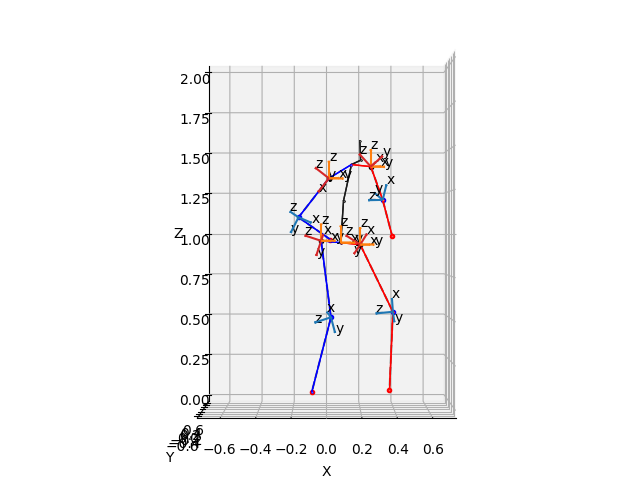

In [76]:
# check visualization
pred_pose_3d = model.module.batch_dh_model.get_batch_pose_3d()
batch_num = 0
frame_num = 100

%matplotlib widget
fig = plt.figure(45)
fig.clear()
ax = axes_3d(fig, [0,0,1,1], xlim=(-0.7, 0.7), ylim=(-0.7, 0.7), zlim=(0, 2), view=(0, -90))
#draw_3d_pose(ax, pred_pose_3d[batch_num, frame_num].cpu().detach().numpy())
model.module.batch_dh_model.draw(ax, batch_num, frame_num, draw_frame=True, draw_gt=True)
draw_3d_pose(ax, batch_pose[batch_num, frame_num])
plt.show()

In [77]:
def rotate_batch_pose_by_R(batch_pose, R):
    assert type(batch_pose) == torch.Tensor, 'batch_pose should be torch.Tensor'
    R = R.to(batch_pose.device).type(batch_pose.dtype)
    if len(batch_pose.shape) == 3:
        batch_pose = batch_pose.unsqueeze(0)
    assert len(batch_pose.shape) == 4, 'batch_pose shape is wrong' # [B, F, 17, 3]
    batch_root = batch_pose[:, :, 0].unsqueeze(2).repeat(1, 1, batch_pose.shape[2], 1) # [B, F, 17, 3]
    batch_pose_root_rel = batch_pose - batch_root
    batch_R = R.unsqueeze(0).unsqueeze(0).repeat(batch_pose.shape[0], batch_pose.shape[1], 1, 1) # [B, F, 3, 3]
    
    return (batch_R @ batch_pose_root_rel.transpose(2, 3)).transpose(2, 3) + batch_root

In [78]:
target = pred_pose_3d[0, 100].clone().detach().unsqueeze(0).unsqueeze(0)
R = torch.tensor(Rotation.from_rotvec(np.array([0, np.pi/2, 0])).as_matrix())
rotated_target = rotate_batch_pose_by_R(torch.tensor(target), R)

%matplotlib widget
fig = plt.figure(46)
fig.clear()
ax = axes_3d(fig, [0,0,1,1], xlim=(-0.7, 0.7), ylim=(-0.7, 0.7), zlim=(0, 2), view=(0, -90))
#draw_3d_pose(ax, pred_pose_3d[batch_num, frame_num].cpu().detach().numpy())
model.module.batch_dh_model.set_batch_dh_model_from_batch_pose(target, batch_size=1, num_frames=1, length_type='first')
#model.module.batch_dh_model.draw(ax, 0, 0, draw_frame=True, draw_gt=True)
model.module.batch_dh_model.set_batch_dh_model_from_batch_pose(rotated_target, batch_size=1, num_frames=1, length_type='first')
model.module.batch_dh_model.draw(ax, 0, 0, draw_frame=True, draw_gt=True)
plt.show()

/tmp/ipykernel_20721/531822621.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rotated_target = rotate_batch_pose_by_R(torch.tensor(target), R)


AssertionError: batch_pose_3d should be (batch_size, num_frames, 17, 3)

In [79]:
## 모든 데이터에 대해 테스트 하기
print('Loading dataset...')
trainloader_params = {
        'batch_size': args.batch_size,
        'shuffle': True,
        'num_workers': 12,
        'pin_memory': True,
        'prefetch_factor': 4,
        'persistent_workers': True
}

testloader_params = {
        'batch_size': args.batch_size,
        'shuffle': False,
        'num_workers': 12,
        'pin_memory': True,
        'prefetch_factor': 4,
        'persistent_workers': True
}
train_dataset = MotionDataset3D(args, args.subset_list, 'train')
test_dataset = MotionDataset3D(args, args.subset_list, 'test')
train_loader = DataLoader(train_dataset, **trainloader_params)
test_loader = DataLoader(test_dataset, **testloader_params)
#datareader = DataReaderKOOKMIN(n_frames=args.clip_len, sample_stride=args.sample_stride, data_stride_train=args.data_stride, data_stride_test=args.clip_len, dt_root = 'data/motion3d', dt_file=args.dt_file)
datareader = DataReaderH36M(n_frames=args.clip_len, sample_stride=args.sample_stride, data_stride_train=args.data_stride, data_stride_test=args.clip_len, dt_root = 'data/motion3d', dt_file=args.dt_file)

Loading dataset...


In [80]:
_, split_id_test = datareader.get_split_id() # [range(0, 243) ... range(102759, 103002)] 
actions = np.array(datareader.dt_dataset['test']['action']) # 103130 ['squat' ...  'kneeup']
factors = np.array(datareader.dt_dataset['test']['2.5d_factor']) # 103130 [3.49990559 ... 2.09230852]
gts = np.array(datareader.dt_dataset['test']['joints_2.5d_image']) # 103130, 17, 3
sources = np.array(datareader.dt_dataset['test']['source']) # 103130 ['S02_6_squat_001' ... 'S08_4_kneeup_001']

num_test_frames = len(actions)
frames = np.array(range(num_test_frames))
action_clips = np.array([actions[split_id_test[i]] for i in range(len(split_id_test))]) # actions[split_id_test]
factor_clips = np.array([factors[split_id_test[i]] for i in range(len(split_id_test))]) # factors[split_id_test]
source_clips = np.array([sources[split_id_test[i]] for i in range(len(split_id_test))]) # sources[split_id_test]
frame_clips  = np.array([frames[split_id_test[i]] for i in range(len(split_id_test))]) # frames[split_id_test]
gt_clips     = np.array([gts[split_id_test[i]] for i in range(len(split_id_test))]) # gts[split_id_test]

In [81]:
mpjpe = 0
batch_num = 0

R1 = Rotation.from_rotvec([-np.pi/2, 0, 0]).as_matrix() # -90 around x-axis
R2 = Rotation.from_rotvec([0, 0, np.pi/2]).as_matrix() # 90 around z-axis
R = torch.tensor(R1 @ R2, dtype=torch.float32)

for batch_input, batch_pose in tqdm(test_loader):
    batch_num += 1
    if batch_pose.shape[0] != args.batch_size:
        continue
    #print(batch_pose.shape)
    #print(loss_limb_var(batch_pose), set(action_clips[batch_num]), set(source_clips[batch_num]))
    #print(get_limb_lens(batch_pose).mean(), get_limb_lens(batch_pose).std())
    
    if len(set(action_clips[batch_num])) > 1: 
        print(batch_num, 'batch action is not same')
    if len(set(source_clips[batch_num])) > 1:
        print(batch_num, 'batch source is not same')
        
    #batch_pose_rotated = rotate_batch_pose_by_R(batch_pose, R)
        
    # update dh model from batch pose
    model.module.batch_dh_model.set_batch_dh_model_from_batch_pose(batch_pose, batch_size=8, length_type='each')
    # calculate mpjpe between gt and dh model
    mpjpe += model.module.batch_dh_model.batch_mpjpe(batch_pose)
    
print(mpjpe/batch_num)

  0%|          | 0/279 [00:00<?, ?it/s]

100%|██████████| 279/279 [00:03<00:00, 82.96it/s] 

tensor(8.5432e-09, device='cuda:0')


In [67]:
pred_pose_3d.shape

torch.Size([4, 243, 17, 3])

In [89]:
model.module.batch_dh_model.set_batch_dh_model_from_batch_pose(batch_pose, length_type='each')
print(model.module.batch_dh_model.get_batch_appendage_length()[0][:, 1])

tensor([0.1073, 0.1070, 0.1067, 0.1064, 0.1062, 0.1060, 0.1058, 0.1056, 0.1054,
        0.1053, 0.1052, 0.1050, 0.1049, 0.1049, 0.1048, 0.1047, 0.1046, 0.1045,
        0.1043, 0.1042, 0.1041, 0.1040, 0.1038, 0.1037, 0.1036, 0.1034, 0.1033,
        0.1032, 0.1030, 0.1029, 0.1028, 0.1026, 0.1024, 0.1022, 0.1020, 0.1018,
        0.1017, 0.1017, 0.1017, 0.1018, 0.1018, 0.1019, 0.1018, 0.1018, 0.1017,
        0.1017, 0.1016, 0.1017, 0.1018, 0.1019, 0.1021, 0.1023, 0.1026, 0.1030,
        0.1033, 0.1037, 0.1041, 0.1046, 0.1050, 0.1055, 0.1059, 0.1064, 0.1069,
        0.1074, 0.1079, 0.1083, 0.1087, 0.1092, 0.1097, 0.1101, 0.1106, 0.1110,
        0.1115, 0.1119, 0.1124, 0.1128, 0.1133, 0.1138, 0.1143, 0.1147, 0.1152,
        0.1157, 0.1162, 0.1167, 0.1173, 0.1178, 0.1184, 0.1189, 0.1195, 0.1200,
        0.1206, 0.1212, 0.1218, 0.1224, 0.1231, 0.1238, 0.1244, 0.1251, 0.1258,
        0.1265, 0.1272, 0.1279, 0.1285, 0.1290, 0.1295, 0.1299, 0.1303, 0.1306,
        0.1309, 0.1312, 0.1314, 0.1317, 

tensor(1.0668e-08, device='cuda:0')


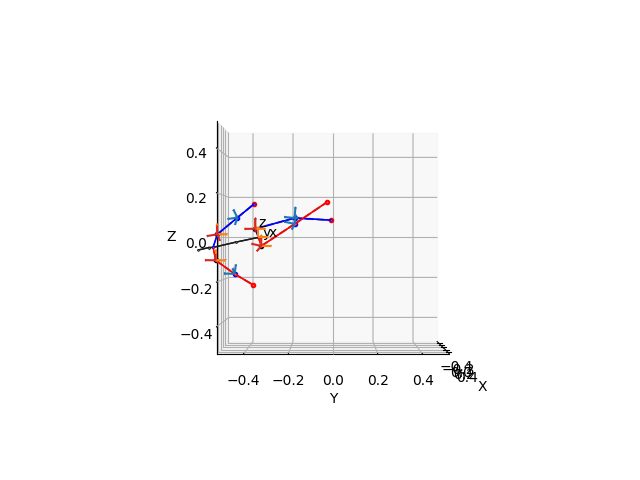

In [69]:
# check visualization
model.module.batch_dh_model.set_batch_dh_model_from_batch_pose(batch_pose, length_type='each')
print(model.module.batch_dh_model.batch_mpjpe(batch_pose))
pred_pose_3d = model.module.batch_dh_model.get_batch_pose_3d()
batch_num = 0
frame_num = 0

%matplotlib widget
fig = plt.figure(45)
fig.clear()
ax = axes_3d(fig, xlim=(-0.5, 0.5), ylim=(-0.5,0.5), zlim=(-0.5,0.5), view=(0, 0))
#draw_3d_pose(ax, pred_pose_3d[batch_num, frame_num].cpu().detach().numpy())
model.module.batch_dh_model.draw(ax, batch_num, frame_num, draw_frame=True, draw_gt=True, head_length=0.005, scale=0.05, fontsize=1)
draw_3d_pose(ax, batch_pose[batch_num, frame_num])
plt.show()

In [ ]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import imageio

videowriter = imageio.get_writer('/home/hrai/codes/PoseAdaptor/test.mp4', fps=30)

stride = 1
end = 100 # len(pose3d_s1_walking)
fig = plt.figure()
for frame in tqdm(range(0, end, stride)):
    fig.clear()
    ax = axes_3d(fig, rect=[0, 0, 1, 1], xlim=(-2, 2), ylim=(-2, 2), zlim=(0, 2), view=(20, -90))
    draw_3d_pose(ax, test_labels[0][frame])
#     canvas = FigureCanvas(fig)
#     canvas.draw()
#     image_from_plot = np.array(canvas.renderer._renderer)
#     image_from_plot = cv2.cvtColor(image_from_plot, cv2.COLOR_RGB2BGR)
#     videowriter.append_data(image_from_plot)
# videowriter.close()

In [69]:
batch_num = 10
len(set(action_clips[batch_num])), set(source_clips[batch_num])

(1, {'S08_3_pushup_001'})

In [125]:
train_data, test_data, train_labels, test_labels = datareader.get_sliced_data()
#print(train_data.shape, test_data.shape)
assert len(train_data) == len(train_labels)
assert len(test_data) == len(test_labels)

(1559752, 17, 2) (566920, 17, 2)


In [127]:
test_labels.shape

(2228, 243, 17, 3)

In [134]:
test_labels[:8].shape

(243, 243, 17, 3)

In [150]:
# mpjpe = 0
# batch_num = 0
# for batch_pose in test_labels:

batch_size = 1
model.module.batch_size = batch_size
# update dh model from batch pose
model.module.batch_dh_model.set_batch_dh_model_from_batch_pose(test_labels[:batch_size], batch_size=batch_size, length_type='first')
# calculate mpjpe between gt and dh model
mpjpe = model.module.batch_dh_model.batch_mpjpe(test_labels[:batch_size])

print(mpjpe)

tensor(0.0023, device='cuda:0')


In [154]:
test_labels[0].shape

(243, 17, 3)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 54.91it/s]


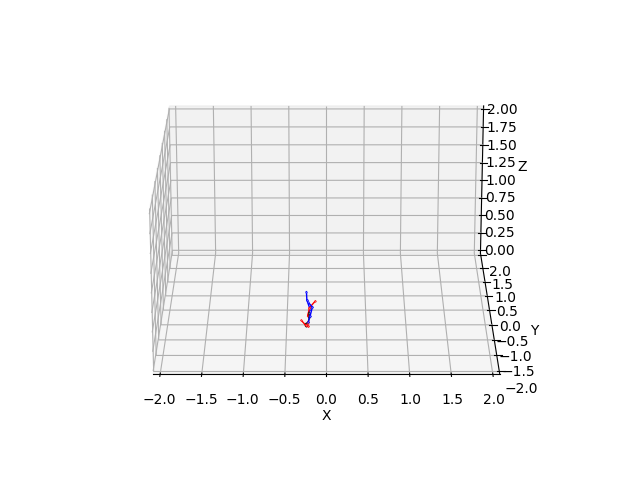

In [155]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import imageio

videowriter = imageio.get_writer('/home/hrai/codes/PoseAdaptor/test_batch_dh_model.mp4', fps=30)

stride = 1
end = 100 # len(pose3d_s1_walking)
fig = plt.figure()
for frame in tqdm(range(0, end, stride)):
    fig.clear()
    ax = axes_3d(fig, rect=[0, 0, 1, 1], xlim=(-2, 2), ylim=(-2, 2), zlim=(0, 2), view=(20, -90))
    draw_3d_pose(ax, test_labels[0][frame])
#     canvas = FigureCanvas(fig)
#     canvas.draw()
#     image_from_plot = np.array(canvas.renderer._renderer)
#     image_from_plot = cv2.cvtColor(image_from_plot, cv2.COLOR_RGB2BGR)
#     videowriter.append_data(image_from_plot)
# videowriter.close()

### Check adaptive average pooling

In [ ]:
import torch
import torch.nn.functional as F

x = torch.randn((8, 243, 17, 3)).cuda()
print(x.shape)
x1 = F.avg_pool2d(x, x.size()[2:])
print(x1.shape)
x2 = F.adaptive_avg_pool2d(x, (9, 3))
print(x2.shape)
x3 = torch.mean(x.view(x.size(0), x.size(1), -1), dim=2)
print(x3.shape)